In [20]:
import sys
print(sys.executable)
!python -m pip install "kagglehub[pandas-datasets]" matplotlib seaborn


c:\Users\luisl\OneDrive\Desktop\ML-Final-Project\.venv\Scripts\python.exe
     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     -------- ------------------------------ 61.4/294.9 kB 1.6 MB/s eta 0:00:01
     ------------------------------- ------ 245.8/294.9 kB 3.0 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 3.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pandas as pd

df = pd.read_csv("online_gaming_behavior_dataset.csv")
df.head()


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium


In [22]:
#inspect our dataset
df.shape
df.info()
df.describe(include='all')
print("\nMissing values per column:")
df.isnull().sum()
print("\nEngagement Level distribution:")
print(df["EngagementLevel"].value_counts())
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

Index(['PlayerID', 'Age', 'Gender', 'Location', 'GameGenre', 'PlayTimeHours',
       'InGamePurchases', 'GameDifficulty', 'SessionsPerWeek',
       'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked',
       'EngagementLevel'],
      dtype='object')

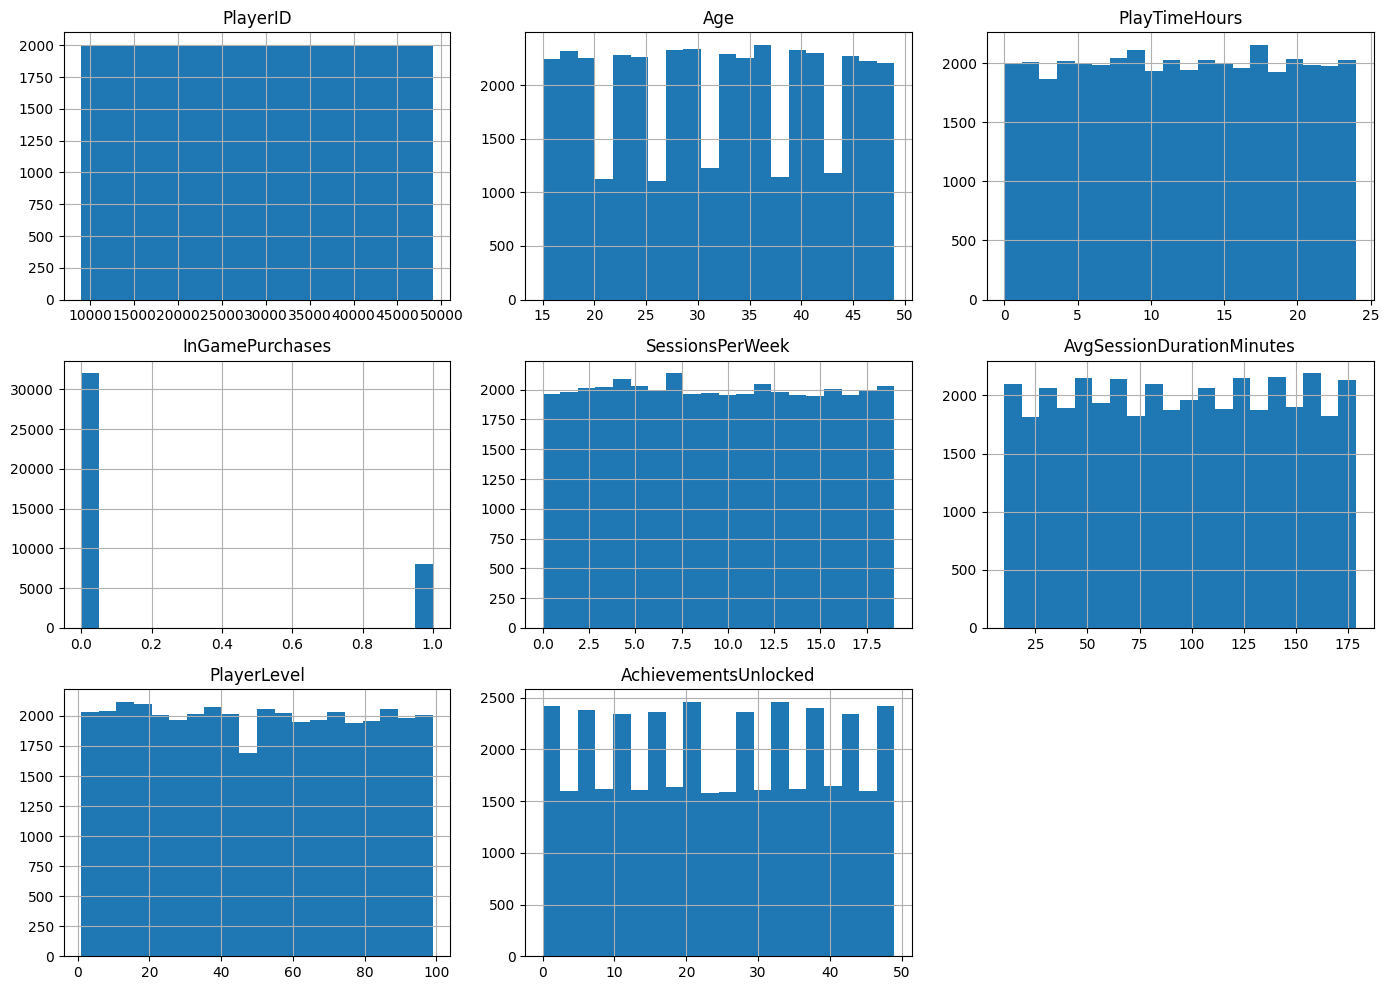

In [ ]:
import matplotlib.pyplot as plt

# histograms of our numerical columns 
df.hist(figsize=(14, 10), bins=20)
plt.tight_layout()
plt.show()



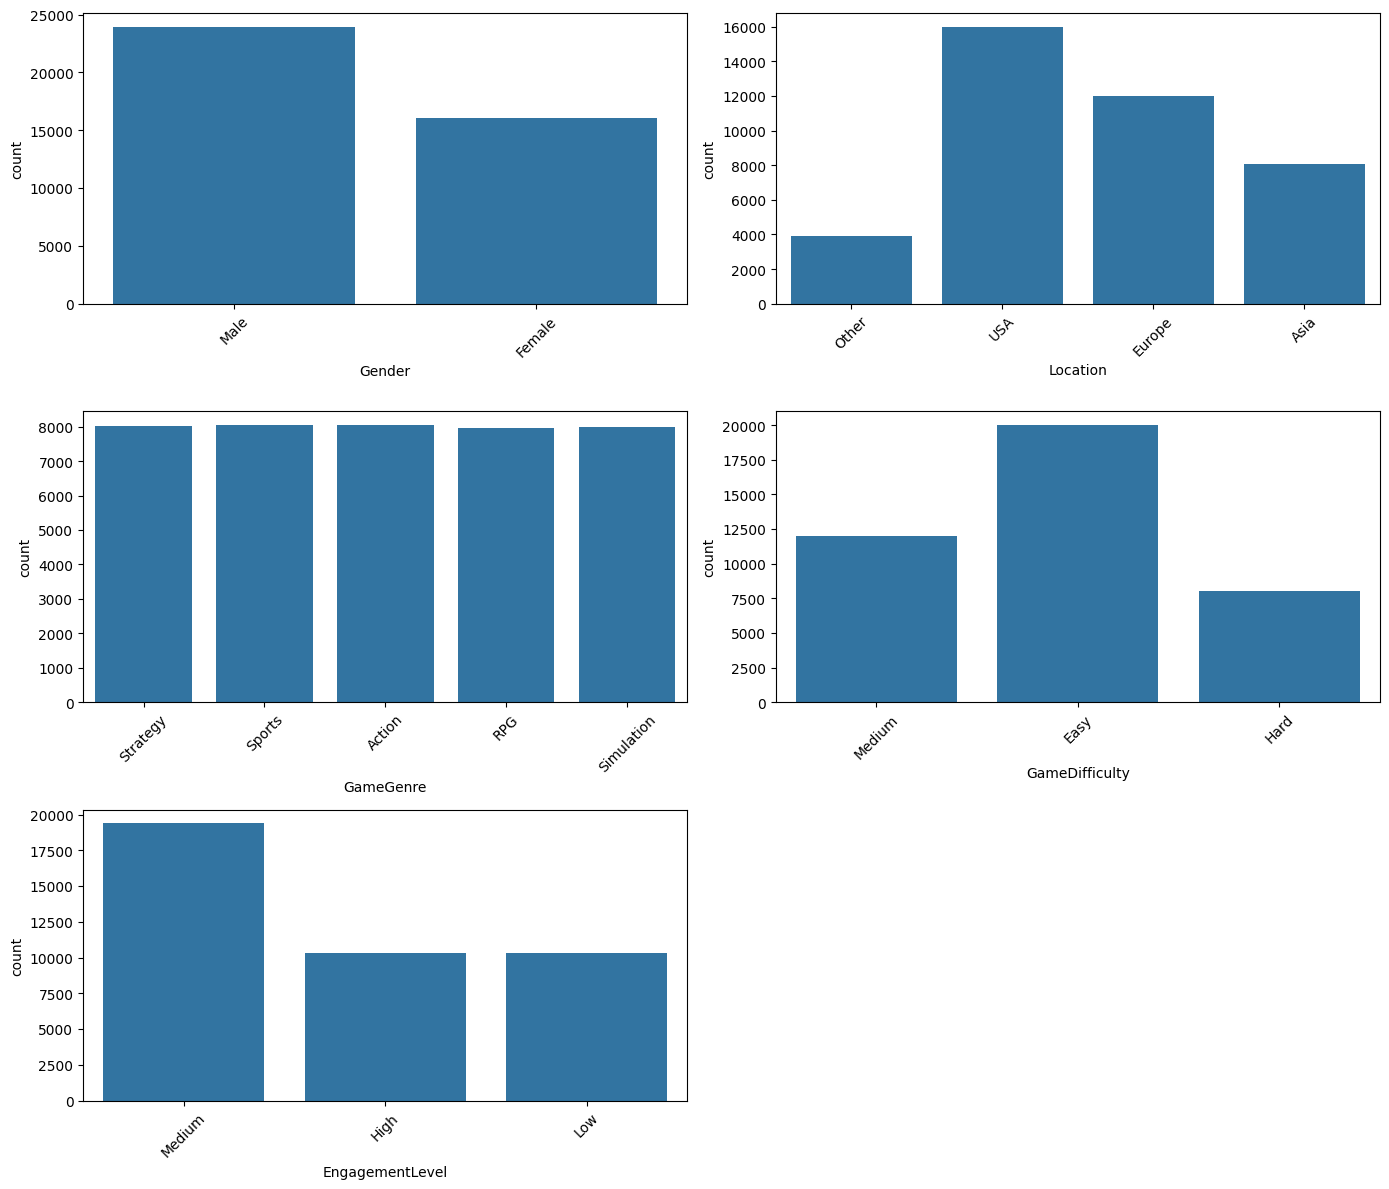

In [ ]:
# bar graphs of categorical data
categorical_cols = ["Gender", "Location", "GameGenre", "GameDifficulty", "EngagementLevel"]

plt.figure(figsize=(14, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

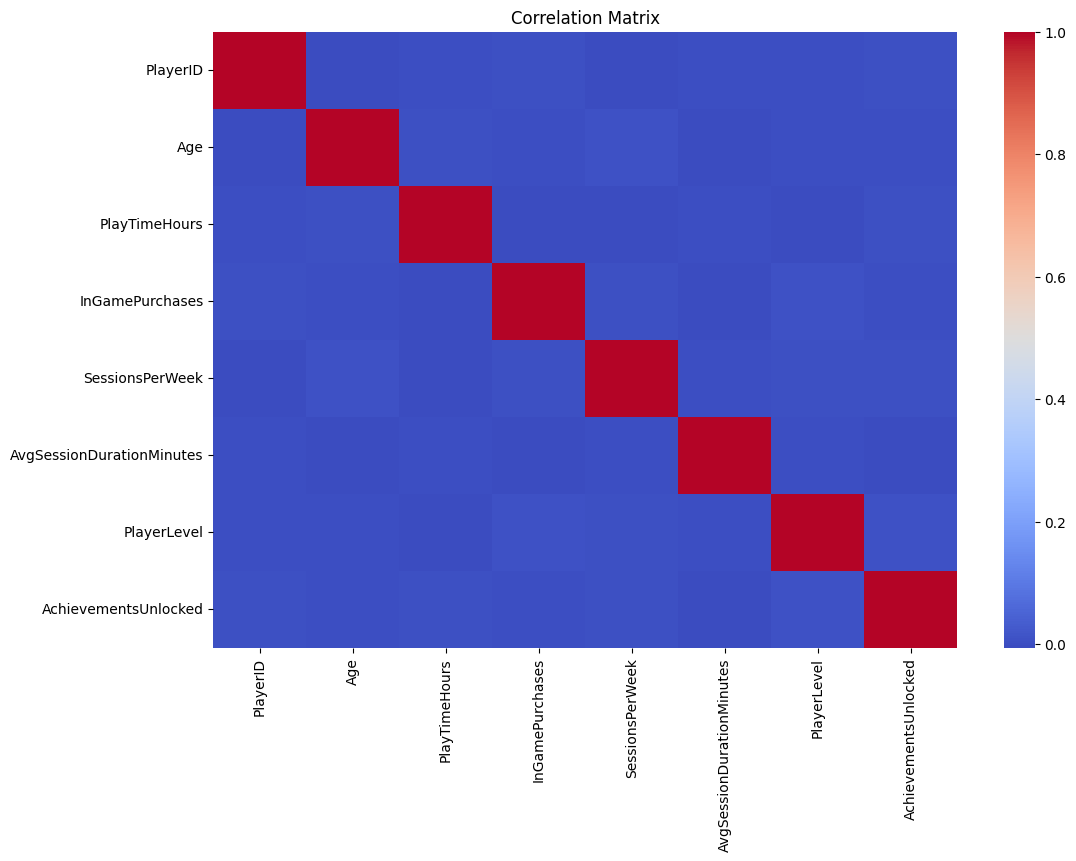

In [27]:
# confusion matrix of our numerical dataset
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# box plots 
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(14, 8))
df[numeric_cols].boxplot(rot=45)
plt.title("Boxplots of Numeric Features")
plt.show()


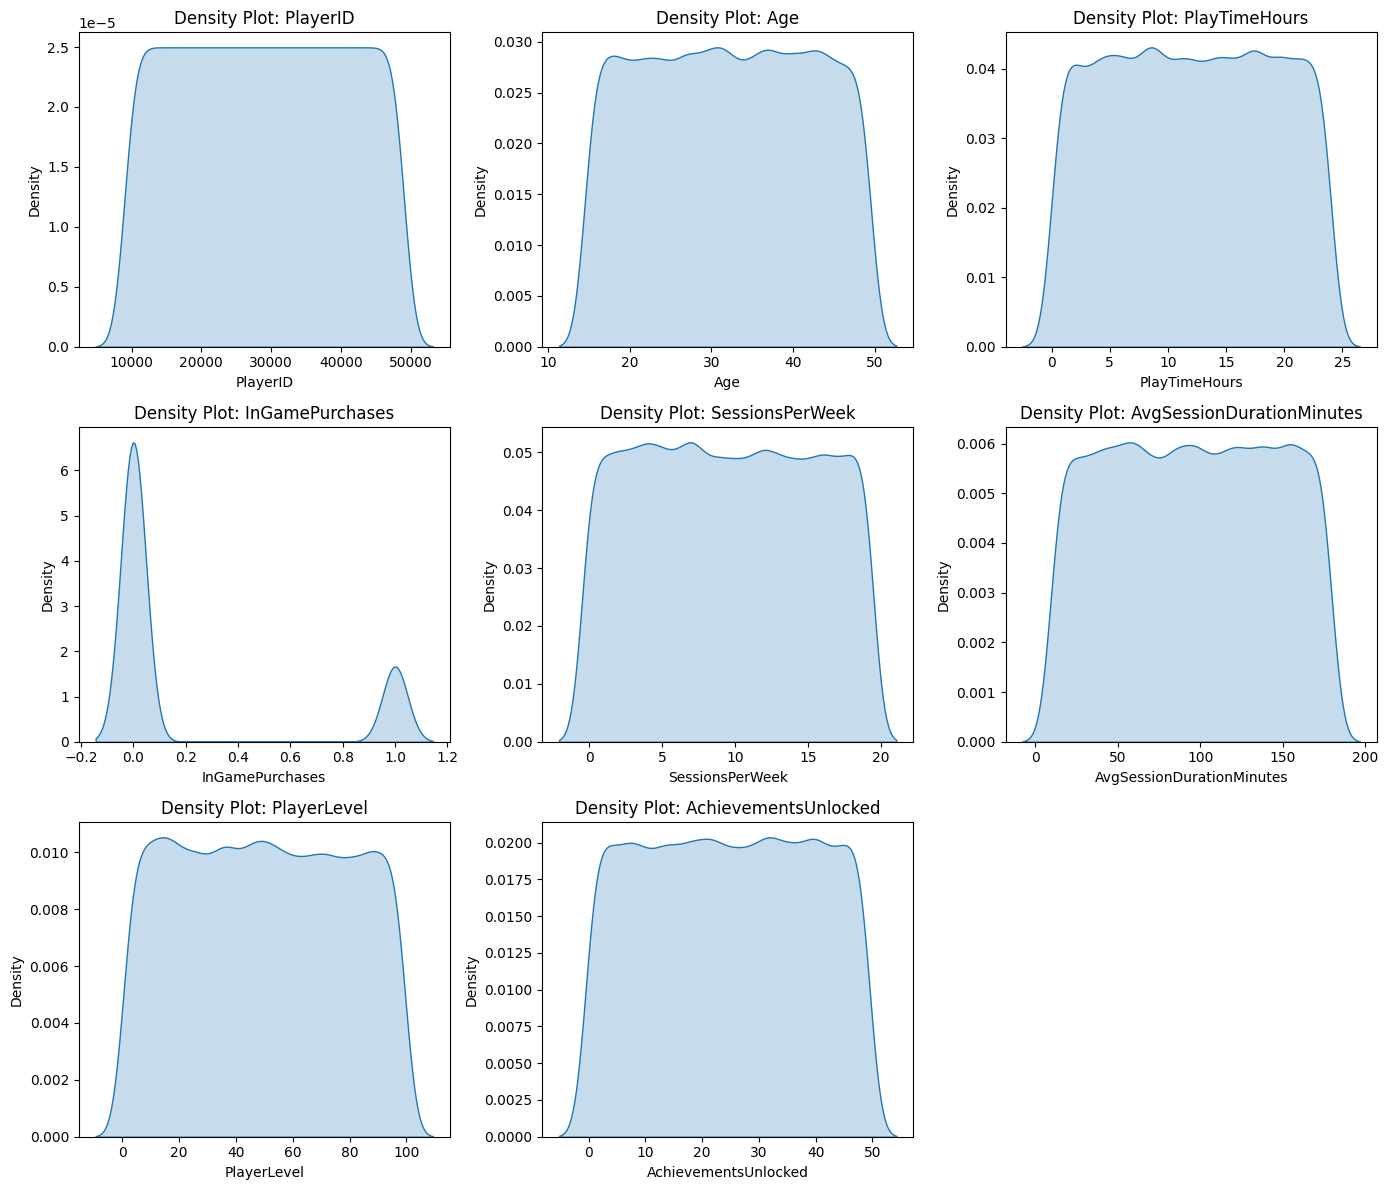

In [29]:
# DENSITY PLOTS (distribution + smooth curves)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(14, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.kdeplot(data=df, x=col, fill=True)
    plt.title(f"Density Plot: {col}")

plt.tight_layout()
plt.show()
